In [1]:
# Install pandasql
!pip install pandasql

^C


# Import Libraries

In [1]:
import json
import pandasql
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Loading a dataset

In [2]:
# Load the processed dataset. 

request_db = pd.read_csv('Dataset/raw_request_dataset.csv')
request_db.head(5)

,day_of_week,Hour,Minute,ride_id,passenger_id,driver_id,undiscounted_fare,rating,ride_duration,ride_distance,status
0,1,5,48,78A5RS,4194635,5271687,121.0,NaN,651.0,6077.0,COMPLETED
1,1,7,37,78A9FQ,5390069,3801157,116.0,NaN,1375.0,5733.0,COMPLETED
2,1,7,47,78AACQ,3750224,5102685,194.0,4.0,1566.0,10913.0,COMPLETED
3,1,8,27,78AFLP,4419899,4869168,66.0,1.0,306.0,2430.0,COMPLETED
4,1,8,41,78AIEB,3802452,2928777,130.0,5.0,1088.0,6686.0,COMPLETED


In [3]:
query = '''
            SELECT 
                day_of_week
                ,Hour
                ,Minute
                ,ride_id
                ,passenger_id
                ,driver_id
                ,rating
                ,status
                ,undiscounted_fare
                      
            FROM 
                request_db
            Group BY driver_id   
            
        '''

trips = pandasql.sqldf(query, globals())
trips.head(5)


,day_of_week,Hour,Minute,ride_id,passenger_id,driver_id,rating,status,undiscounted_fare
0,1,1,3,78A4KK,4866388,0,NaN,CANCELED,NaN
1,5,16,21,791G0R,5236165,2869204,NaN,COMPLETED,93.0
2,3,10,16,78KTR2,3144778,2869278,NaN,CANCELED,NaN
3,2,17,14,78GQA8,4519887,2870173,4.0,COMPLETED,61.0
4,4,21,3,78SJP6,4851288,2886584,4.0,COMPLETED,137.0


In [4]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   day_of_week        3000 non-null   int64  
 1   Hour               3000 non-null   int64  
 2   Minute             3000 non-null   int64  
 3   ride_id            3000 non-null   object 
 4   passenger_id       3000 non-null   int64  
 5   driver_id          3000 non-null   int64  
 6   rating             1350 non-null   float64
 7   status             3000 non-null   object 
 8   undiscounted_fare  2712 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 211.1+ KB


In [5]:
query = '''
            SELECT 
                day_of_week
                ,Hour
                ,Minute
                ,ride_id
                ,passenger_id
                ,driver_id
                ,rating
                ,status
                ,undiscounted_fare
                      
            FROM 
                request_db
            Group BY driver_id   
            
        '''

completed_trips = pandasql.sqldf(query, globals())
completed_trips.head(5)


,day_of_week,Hour,Minute,ride_id,passenger_id,driver_id,rating,status,undiscounted_fare
0,1,1,3,78A4KK,4866388,0,NaN,CANCELED,NaN
1,5,16,21,791G0R,5236165,2869204,NaN,COMPLETED,93.0
2,3,10,16,78KTR2,3144778,2869278,NaN,CANCELED,NaN
3,2,17,14,78GQA8,4519887,2870173,4.0,COMPLETED,61.0
4,4,21,3,78SJP6,4851288,2886584,4.0,COMPLETED,137.0


### Now let's try to answer some questions in order to understand the datatset and inferences we can incur from there.

 - How many trips were completed or canceled?
 - Top 5 drivers based on rating
 - Drivers with most distance covered
 - Assignment to completed ratio
 - Which day of the week is more profitable for drivers? (based on Completed trips and fare)
 - Drivers with most cancelled trips

## How many trips were completed or canceled?

In [6]:
print('Total trips: ', trips.status.count())
print(trips.status.value_counts())
print(round(trips.status.value_counts()/trips.status.size*100,2))
#print(completed_trips.status.count()/trips.status.count())

#trips.groupby(by=['driver_id'])['status'].value_counts(normalize=True).unstack('status').plot.bar(stacked=True);


Total trips:  3000
COMPLETED    2712
CANCELED      288
Name: status, dtype: int64
COMPLETED    90.4
CANCELED      9.6
Name: status, dtype: float64


# Calculate Demand and Reliability 
##  Unwillingness of drivers to accommodate trips.

From below calculations we can see 9.6% of the total demand has been canceled. Considering the total rides (3000) in this calculations this percentage still a bit high. We need to take measure to understand who (driver or customer) have cancelled most of this trips and take necessary steps to solve the issue.

           Total Rides     %
COMPLETED         2712  90.4
CANCELED           288   9.6


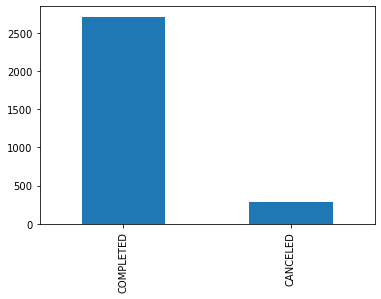

In [7]:
# Creating a series with product types rides
pt_rides = pd.Series(completed_trips.status.value_counts().sort_index(ascending=False))

#Transforming series into dataframe
df = pd.DataFrame(pt_rides)

#Including new column with trips portion
df['%'] = (completed_trips.status.value_counts().sort_index(ascending=False)/trips.status.size*100).round(1)

#Renaming column labels
df.rename(columns={'status':'Total Rides'},inplace=True)

print(df)

#Plotting product types count
completed_trips['status'].value_counts().plot(kind='bar');

## Top 5 drivers based on rating

In [8]:
query = '''
            SELECT 
            
                driver_id
                ,max(rating) as highest_rating
                ,status
                      
            FROM 
                request_db    
            Group BY driver_id
            Order BY rating DESC
            Limit 5
            
        '''

high_rated_drivers = pandasql.sqldf(query, globals())
high_rated_drivers.head(5)

,driver_id,highest_rating,status
0,5441084,5.0,COMPLETED
1,5439508,5.0,COMPLETED
2,5439220,5.0,COMPLETED
3,5439209,5.0,COMPLETED
4,5438905,5.0,COMPLETED


### Drivers who have covered most distance

In [9]:
query = '''
            SELECT 
                driver_id
                ,max(rating) as highest_rating
                ,sum(ride_distance)/1000 as total_distance_covered_km
                ,status
                      
            FROM 
                request_db    
            Group BY driver_id
            Order BY total_distance_covered_km DESC
            Limit 5
            
        '''

most_distance_covered = pandasql.sqldf(query, globals())
most_distance_covered.head(5)

,driver_id,highest_rating,total_distance_covered_km,status
0,4598077,5.0,733.900,COMPLETED
1,5255479,5.0,620.066,COMPLETED
2,4834241,5.0,564.971,COMPLETED
3,5026569,5.0,563.687,COMPLETED
4,5221083,5.0,549.606,COMPLETED


## Most active day of the week

In [10]:
query = '''
            SELECT 
                
                ride_id
                ,day_of_week
                ,Sum(CASE when status = 'COMPLETED' then 1 else 0 end) as completed_rides
                ,Sum(undiscounted_fare) as fare
                      
            FROM 
                request_db    
            Group BY day_of_week
            Order BY fare DESC
            Limit 10
            
        '''

most_profitable_day = pandasql.sqldf(query, globals())
most_profitable_day.head(5)

,ride_id,day_of_week,completed_rides,fare
0,78DO6G,2,10206,1038352.0
1,78A5RS,1,9359,960966.0
2,78T26O,5,9112,947953.0
3,78JDGB,3,9224,935009.0
4,78ORFC,4,8419,883381.0


In [11]:
most_profitable_day.to_csv('Dataset/most_profitable_day.csv')

### Drivers with most canceled trips

In [12]:
query = '''
            SELECT 
                
                driver_id
                ,Sum(CASE when status = 'CANCELED' then 1 else 0 end) as canceled_rides
                      
            FROM 
                request_db    
            Group BY driver_id
            Order BY canceled_rides DESC
            Limit 10
            
        '''

most_canceled_rides = pandasql.sqldf(query, globals())
most_canceled_rides.head(5)

,driver_id,canceled_rides
0,0,16985
1,5311075,183
2,5309242,109
3,5366602,107
4,5289967,104


In [13]:
# Load the driver ride assignment dataset

ride_assign_db = pd.read_csv('Dataset/driver_ride_assignments.csv')
ride_assign_db.head(5)

,ride_id,driver_id
0,78A5D3,4922405
1,78A5D3,5332197
2,78A604,5303157
3,78A604,3355215
4,78A604,5265495


In [15]:
query = '''
            SELECT
                ride_id
                ,driver_id
                ,Count(Distinct ride_id) as total_assigned
                
                      
            FROM 
                ride_assign_db   
            Group BY driver_id
            
        '''

total_ride_assigned = pandasql.sqldf(query, globals())
total_ride_assigned.head(5)

,ride_id,driver_id,total_assigned
0,78TN7S,2869108,1
1,78RD6L,2869204,99
2,797G7D,2869278,11
3,78B3SO,2870173,285
4,7.97E+10,2886584,189


In [16]:
total_ride_assigned.to_csv('Dataset/total_ride_assigned.csv')

### Calculating ACR

In [17]:
query = '''
            SELECT 
            
                ra.driver_id
                ,day_of_week
                ,Count(Distinct day_of_week) as total_days
                ,Hour
                ,Minute 
                ,passenger_id
                ,Count(status) as total_requests
                ,ra.total_assigned
                ,Avg(rating) as avg_rating
                ,Sum(CASE when status = 'COMPLETED' then 1 else 0 end) as completed_rides
                ,Sum(CASE when status = 'COMPLETED' then 1 else 0 end) / ra.total_assigned as ACR
                ,status
                ,Sum(ride_duration) / 3600 as ride_duration_hour
                ,sum(ride_distance)/1000 as total_distance_covered_km
                ,Avg(undiscounted_fare) as avg_fare
                      
            FROM 
                request_db r
            Join total_ride_assigned ra        
            On r.driver_id = ra.driver_id        
            Group BY ra.driver_id
            Order By total_days desc
        
            
        '''

total_assigned = pandasql.sqldf(query, globals())
total_assigned.head(5)


,driver_id,day_of_week,total_days,Hour,Minute,passenger_id,total_requests,total_assigned,avg_rating,completed_rides,ACR,status,ride_duration_hour,total_distance_covered_km,avg_fare
0,5397054,7,7,15,57,4186644,64,91,4.233333,51,0,COMPLETED,12.793611,201.456,92.392157
1,5397002,7,7,2,38,5110289,45,268,4.000000,27,0,COMPLETED,7.282500,129.245,108.074074
2,5396999,3,7,22,12,5161336,54,223,4.388889,40,0,COMPLETED,9.922778,185.126,105.600000
3,5396817,2,7,18,38,3043378,33,121,4.500000,19,0,COMPLETED,5.076111,73.232,90.368421
4,5396502,5,7,19,38,4750805,65,196,4.608696,42,0,COMPLETED,9.806944,209.125,112.166667


In [19]:
ACR_Data_cleaned = pd.read_csv('Dataset/ACR_Data.csv')

In [20]:
df = pd.DataFrame(ACR_Data_cleaned)

In [21]:
print(df.isnull().sum())

Unnamed: 0                   0
driver_id                    0
day_of_week                  0
total_days                   0
Hour                         0
Minute                       0
passenger_id                 0
total_requests               0
total_assigned               0
avg_rating                   0
completed_rides              0
ACR                          0
status                       0
ride_duration_hour           0
total_distance_covered_km    0
avg_fare                     0
dtype: int64


In [22]:
# dropping the null rows
df.dropna(subset = ["ride_duration_hour","total_distance_covered_km","avg_fare"], inplace=True)
df.head()

,Unnamed: 0,driver_id,day_of_week,total_days,Hour,Minute,passenger_id,total_requests,total_assigned,avg_rating,completed_rides,ACR,status,ride_duration_hour,total_distance_covered_km,avg_fare
0,0,5397054,7,7,15,57,4186644,64,91,4.233333,51,0.560440,COMPLETED,12.793611,201.456,92.392157
1,1,5397002,7,7,2,38,5110289,45,268,4.000000,27,0.100746,COMPLETED,7.282500,129.245,108.074074
2,2,5396999,3,7,22,12,5161336,54,223,4.388889,40,0.179372,COMPLETED,9.922778,185.126,105.600000
3,3,5396817,2,7,18,38,3043378,33,121,4.500000,19,0.157025,COMPLETED,5.076111,73.232,90.368421
4,4,5396502,5,7,19,38,4750805,65,196,4.608696,42,0.214286,COMPLETED,9.806944,209.125,112.166667


In [24]:
# Replacing null rating values is 0 where status is Completed

df['avg_rating'] = df['avg_rating'].fillna(df['avg_rating'].mean()) 
df.tail()

,Unnamed: 0,driver_id,day_of_week,total_days,Hour,Minute,passenger_id,total_requests,total_assigned,avg_rating,completed_rides,ACR,status,ride_duration_hour,total_distance_covered_km,avg_fare
2770,2993,2928430,3,1,15,21,5078476,5,10,4.000000,2,0.200000,COMPLETED,0.858056,12.975,133.0
2771,2994,2927864,5,1,13,3,5162511,5,6,3.750000,5,0.833333,COMPLETED,1.215278,18.579,90.2
2772,2995,2927397,7,1,18,7,5442177,1,5,4.307564,1,0.200000,COMPLETED,0.577500,4.571,99.0
2773,2996,2925573,2,1,21,24,4568992,4,5,4.666667,4,0.800000,COMPLETED,0.478611,15.240,99.0
2774,2997,2904200,1,1,19,40,4962826,2,6,5.000000,1,0.166667,COMPLETED,0.291944,6.225,123.0


In [86]:
df.to_csv('Dataset/ACR_Data.csv')

In [25]:
query = '''
            SELECT 
            
                driver_id
                ,Count(status) as total_completed_request
                      
            FROM 
                completed_trips
                
            Where driver_id = '4598077'    
            Group BY driver_id
        
            
        '''

total_completed_request = pandasql.sqldf(query, globals())
total_completed_request.head(5)

,driver_id,total_completed_request
0,4598077,1


## Driver Performance Profile analysis


In [26]:
#import cleaned dataset
driver = pd.read_csv('Dataset/ACR_Data.csv')
driver.head(5)



,Unnamed: 0,driver_id,day_of_week,total_days,Hour,Minute,passenger_id,total_requests,total_assigned,avg_rating,completed_rides,ACR,status,ride_duration_hour,total_distance_covered_km,avg_fare
0,0,5397054,7,7,15,57,4186644,64,91,4.233333,51,0.560440,COMPLETED,12.793611,201.456,92.392157
1,1,5397002,7,7,2,38,5110289,45,268,4.000000,27,0.100746,COMPLETED,7.282500,129.245,108.074074
2,2,5396999,3,7,22,12,5161336,54,223,4.388889,40,0.179372,COMPLETED,9.922778,185.126,105.600000
3,3,5396817,2,7,18,38,3043378,33,121,4.500000,19,0.157025,COMPLETED,5.076111,73.232,90.368421
4,4,5396502,5,7,19,38,4750805,65,196,4.608696,42,0.214286,COMPLETED,9.806944,209.125,112.166667


### Driver performance analysis visualization

In [27]:
query = '''
            SELECT 
            
                driver_id
                ,day_of_week
                ,total_days
                ,total_requests
                ,total_assigned
                ,avg_rating
                ,completed_rides
                ,ACR
                ,status
                ,avg_fare
                      
            FROM 
                driver     
            Group BY driver_id
            Order By ACR
        
            
        '''

driver_performance = pandasql.sqldf(query, globals())
driver_performance.head(5)


,driver_id,day_of_week,total_days,total_requests,total_assigned,avg_rating,completed_rides,ACR,status,avg_fare
0,4578297,2,3,8,248,4.307564,1,0.004032,CANCELED,88.0
1,3367068,3,4,40,243,4.000000,1,0.004115,CANCELED,90.0
2,5412376,7,3,13,214,5.000000,1,0.004673,CANCELED,94.0
3,4679813,4,7,37,168,4.307564,1,0.005952,CANCELED,99.0
4,5312134,2,5,11,155,4.307564,1,0.006452,COMPLETED,71.0


In [28]:
driver_performance.to_csv('Dataset/driver_performance.csv')

In [29]:
query = '''
            SELECT 
                *
            FROM 
                driver_performance
            Group BY driver_id 
            Order By ACR desc
            Limit 5
            
            
        '''

top_5drivers_rides_completion = pandasql.sqldf(query, globals())
top_5drivers_rides_completion.head(5)


,driver_id,day_of_week,total_days,total_requests,total_assigned,avg_rating,completed_rides,ACR,status,avg_fare
0,5440699,7,1,5,5,4.307564,5,1.0,COMPLETED,93.4
1,5338953,4,1,2,2,4.000000,2,1.0,COMPLETED,54.5
2,5326434,3,1,2,2,4.307564,2,1.0,COMPLETED,134.0
3,5318376,1,1,1,1,4.307564,1,1.0,COMPLETED,80.0
4,5305674,2,1,3,3,4.666667,3,1.0,COMPLETED,84.0


### Ride completion number and average rating comparison chart (weekly)

From below charts we can see the relationship between completed rides and average rating in different days of the week. One thing we can infer from the chart is high ratings (>4.5) when the completed rides number is low. We can see when the rides number is low (earlier in the day) the high ratings are appear then decrease to a moderate number. There are various reason this can happen like for example due to short number of ride quantity, morning freshness of the customers encourage them to provide a good rating, lesser traffic jam, lower chance of mechanical problem or fuel refill. However these factors can affect in later part of the day which might irritate some rider after a tiring day can eventually provoke them to provide a poor rating (despite giving a good service as a driver) which affect the overall rating. So rating might be good indicator to measure driver performance but due to some biases, we should also look at other factors, like ACR, driver's experience, trip completion rate etc. to measure KPI.

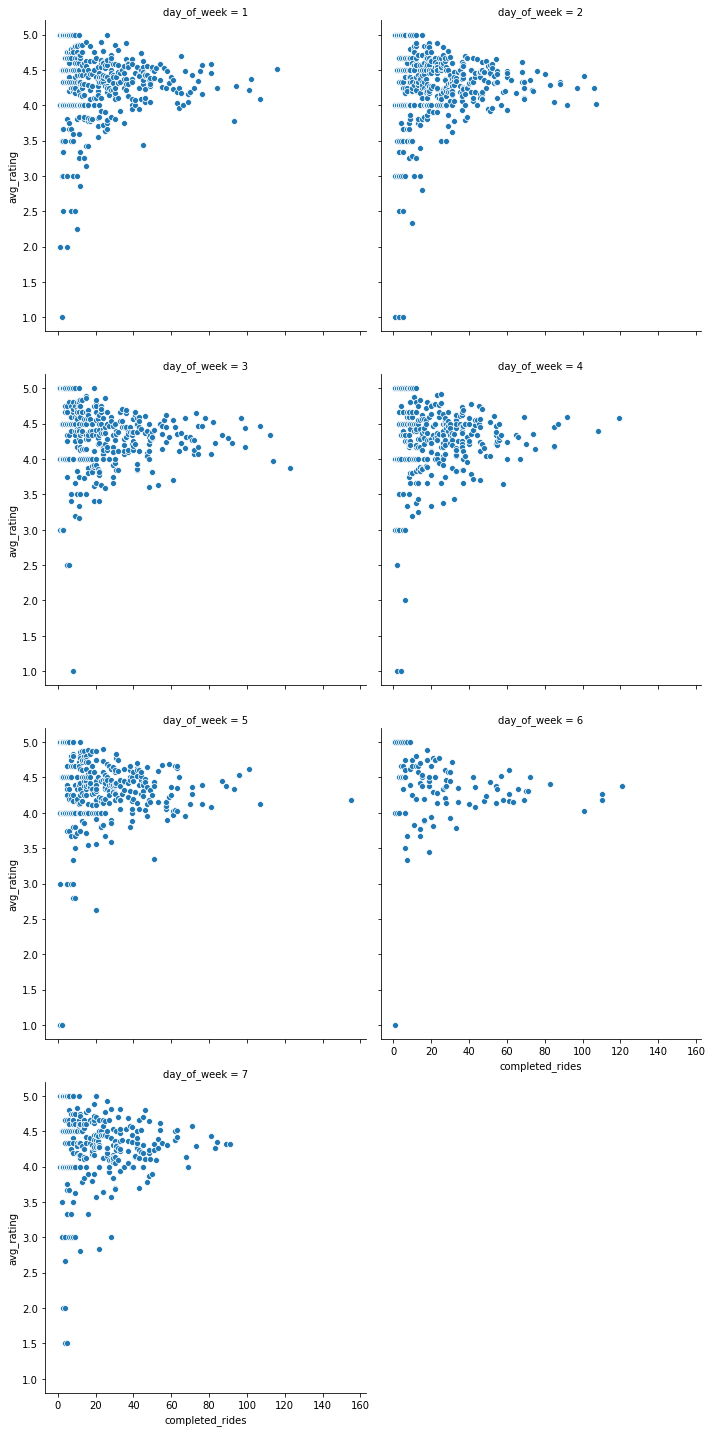

In [63]:
sns.relplot(x='completed_rides',y='avg_rating',data=driver_performance,kind="scatter",col="day_of_week",
            col_wrap=2,col_order=[1,2,3,4,5,6,7])
plt.show()

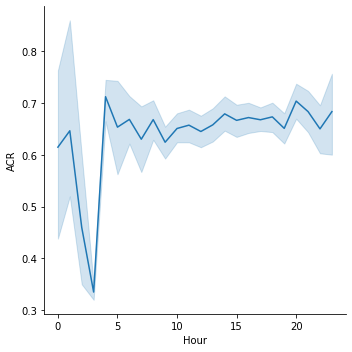

In [48]:
sns.relplot(x='Hour',y='ACR',data=driver_cleaned,kind="line")
plt.show()

From above figure we can see a sharp decrease in ACR in an specific time. Need to figure out reason behind it.

## Driver Performance Metrics Conclusion

From analysis we can infer that we need a combination of multiple metrics to properly measure the performance of drivers. We have identified three performance metrics:

 - Driver Ride accepatance rate or percentage of ride completed (ACR)
 - Driver's rating
 - Ride cancellation rate
 
 We need to add a new metric named 'Driver_Canceled' in our status column in order to properly calculate the cacellation rate of drivers.
 


# Recommendations:


- Improving Reliability
    - Add a new metric named 'Driver_Canceled' in status column. In this way we can easily   
      identify which trips were cancelled by drivers and which trips were canceled by users. 
    - Impose fine for cancelling trips after acceptance. 
    - We can show drivers the potential area user will visit. In this way drivers can better           decide whether they will accept the trip or not.
    - Impose fines for users if a ride is canceled by them after accepting and driver has already       started to pick him/her up.
    - Add a metric to calculate vehicle availability in specific time period. In this way we can       easily calculate in which time period vehicle shortage is happening.
- Driver Performance Metric
    - Add a new feature named 'Driver_Canceled' within status column to identify the rides             canceled by drivers
    - Set some threshold in performance metric. Like for example, ride acceptance rate must be         over 80% and/or cancelation rate must be below 5%.
    - Failure to maintain the above threshold will lead to punishment which ulyimately result in       account deactivation from the platform
    - Appreciate best performing drivers by providing gifts and bounses which will encourage them       to keep pushing forward.

## Task 3: System Design

In [ ]:
#System Design

driver= []
completed_rides  = []
canceled_rides = driver.canceled_rides
rating = driver.rating
ACR = driver.ACR
request = boolean


if request

    for i in driver.length:
        if completed_rides = max(completed_rides) and rating > 4.0:
            
            if ACR > 0.5 and canceled_rides = min(canceled_rides):
                driver = driver.match
        
        i++
 